In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [2]:
data=pd.read_csv('data/JACK.csv')

In [3]:
type(data.index[0])

int

In [4]:
data2=data.set_index('timestamp').sort_index(ascending=False)

# Cleaning data


In [5]:
#converting timestamp row to timestamp type
data2.index=pd.to_datetime(data2.index, utc=True)

In [6]:
# Create a DatetimeIndex and assign it to the dataframe.
data2.index = pd.DatetimeIndex(data2.index)

In [7]:
#Count ticks on unique days
day_tick_cnt = data2.index.normalize() \
                     .value_counts() \
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 240)]

In [8]:
len(day_tick_cnt)- len(day_list)

2690

In [26]:
#create date
data2['date']=data2.index.date

In [27]:
data2.head()

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,dema,...,fastd,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09,46.977,46.92764,46.82764,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN


In [28]:
#if date is in data, keep the data
cond= data2['date'].isin(day_list['index'])
data2.drop(data2[cond].index, inplace = True)

In [29]:
#data should now be cleaned of days where data is spotty
data2.head()

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,dema,...,fastd,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09,46.977,46.92764,46.82764,NaN,...,NaN,NaN,NaN,NaN,4,3,16,NaN,NaN,NaN


In [30]:
#create time frame of opening to one hour before closing/ after hours
#data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [31]:
import talib.abstract as tab

In [32]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        dataframe['rsi'] = tab.RSI(dataframe, timeperiod=20, price='close')
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        dataframe['fastd'] = stoch_fast['fastd']
        dataframe['fastk'] = stoch_fast['fastk']
        dataframe['adx'] = tab.ADX(dataframe)
        dataframe['cci'] = tab.CCI(dataframe)
        
        #create time indicators
        dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        #required for graphing
        #remove for later only here for graphing visualizing
        bollinger =ta.BBANDS(dataframe['close'],timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]

        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

In [33]:
data3=data2

In [34]:
data3=populateindicators(data3).sort_index(ascending=True)

In [35]:
data3[230:290]

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,dema,...,fastd,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 18:43:00+00:00,19.40,19.420,19.3900,19.4200,1800,2008-12-15,19.426847,19.426083,19.415696,19.441277,...,76.897436,76.923077,11.673304,-13.850928,12,0,18,19.345916,19.496064,19.42099
2008-12-15 18:44:00+00:00,19.42,19.420,19.4199,19.4199,2409,2008-12-15,19.430271,19.429125,19.428544,19.443129,...,84.589744,76.846154,11.838848,3.452424,12,0,18,19.342859,19.495121,19.41899
2008-12-15 18:45:00+00:00,19.42,19.420,19.4200,19.4200,100,2008-12-15,19.435407,19.433737,19.432866,19.445149,...,92.307692,76.923077,12.710669,-7.633588,12,0,18,19.340032,19.493968,19.41700
2008-12-15 18:46:00+00:00,19.45,19.450,19.4500,19.4500,200,2008-12-15,19.443110,19.440606,19.439299,19.447323,...,90.740741,100.000000,13.646893,42.257218,12,0,18,19.337411,19.492589,19.41500
2008-12-15 18:47:00+00:00,19.45,19.450,19.4500,19.4500,100,2008-12-15,19.439665,19.435909,19.433948,19.445540,...,81.481481,100.000000,13.834768,44.422178,12,0,18,19.335703,19.484297,19.41000
2008-12-15 18:48:00+00:00,19.45,19.450,19.4500,19.4500,200,2008-12-15,19.434498,19.428863,19.425922,19.443523,...,68.518519,72.222222,14.037095,36.842105,12,0,18,19.334345,19.487655,19.41100
2008-12-15 18:49:00+00:00,19.44,19.450,19.4400,19.4500,200,2008-12-15,19.426747,19.418294,19.413884,19.441249,...,59.259259,72.222222,14.254986,24.911032,12,0,18,19.327250,19.502750,19.41500
2008-12-15 18:52:00+00:00,19.45,19.450,19.4300,19.4300,600,2008-12-15,19.415121,19.402441,19.400825,19.438693,...,35.185185,61.111111,14.489637,1.545254,12,0,18,19.323851,19.512149,19.41800
2008-12-15 18:54:00+00:00,19.42,19.420,19.4000,19.4000,900,2008-12-15,19.397681,19.388662,19.386238,19.438584,...,17.592593,44.444444,14.742339,-48.160000,12,0,18,19.324153,19.513847,19.41900


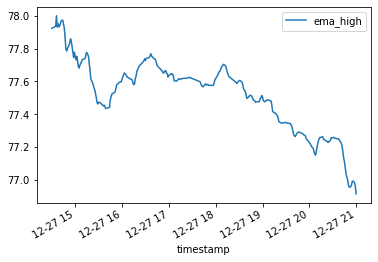

In [37]:
data2['2019-12-27'].plot(y='ema_high')

# Machine Learning Setup

In [38]:
import mlfinlab as ml
import timeit


from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [39]:
data_ml=data[['timestamp','open','volume']]
data_ml.rename(columns={"timestamp": "date_time", "open": "price"})

,date_time,price,volume
0,2020-04-09 09:07:00-04:00,45.3300,135
1,2020-04-09 09:08:00-04:00,44.9000,750
2,2020-04-09 09:26:00-04:00,45.2100,110
3,2020-04-09 09:30:00-04:00,46.0000,29141
4,2020-04-09 09:31:00-04:00,45.9615,7609
...,...,...,...
911448,2008-12-15 15:55:00-05:00,19.4500,2047
911449,2008-12-15 15:56:00-05:00,19.5000,5534
911450,2008-12-15 15:57:00-05:00,19.5500,7063
911451,2008-12-15 15:58:00-05:00,19.4500,4800


# Triple Barrier labelling


In [40]:
#Read in data
data_ml=data3

### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [41]:
# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

In [42]:
data_ml.head()

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,dema,...,fastd,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,20.494904,20.479927,20.476466,20.521633,...,68.690440,10.102031,41.635909,-92.076452,12,0,14,19.735847,21.026333,20.38109
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,20.692356,20.669890,20.664698,20.569340,...,86.944718,95.969290,43.119032,139.920212,12,0,14,19.784685,21.023495,20.40409
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,20.563534,20.529835,20.522048,20.504381,...,65.990991,100.000000,44.207774,187.515241,12,0,14,19.829816,20.934364,20.38209
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,20.350351,20.299803,20.288121,20.426769,...,32.657658,64.864865,45.085975,31.844487,12,0,14,19.905603,20.806597,20.35610
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,20.285526,20.209705,20.192182,20.411093,...,11.343728,33.108108,48.267869,-65.800610,12,0,14,19.899031,20.837169,20.36810


## Fit a Primary Model: Bollinger Band Mean-Reversion

In [43]:
# Compute sides
#when above bb, is 1, when below is -1
data_ml['side'] = np.nan 
long_signals = (data_ml['close'] <= data_ml['bb_lowerband']) 
short_signals = (data_ml['close'] >= data_ml['bb_upperband']) 

data_ml.loc[long_signals, 'side'] = 1
data_ml.loc[short_signals, 'side'] = -1

print(data_ml.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_ml['side'] = data_ml['side'].shift(1)



 1.0    41371
-1.0    39638
Name: side, dtype: int64


In [44]:
# Save the raw data
raw_data = data_ml.copy()

# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

In [46]:
data_ml

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,dema,...,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:37:00+00:00,20.48,20.48,20.4800,20.480,100,2008-12-15,20.350351,20.299803,20.288121,20.426769,...,64.864865,45.085975,31.844487,12,0,14,19.905603,20.806597,20.35610,-1.0
2008-12-15 14:51:00+00:00,20.60,20.60,20.5000,20.600,2100,2008-12-15,20.534352,20.530929,20.488823,20.502932,...,100.000000,63.438948,88.911775,12,0,14,20.320140,20.641860,20.48100,-1.0
2008-12-15 15:02:00+00:00,20.27,20.27,20.2700,20.270,100,2008-12-15,20.248657,20.240171,20.230403,20.249773,...,100.000000,56.340070,106.991870,12,0,15,19.998892,20.361108,20.18000,-1.0
2008-12-15 15:08:00+00:00,20.25,20.25,20.0000,20.000,2572,2008-12-15,20.152197,20.066792,20.055524,20.157072,...,0.000000,56.616926,-233.333333,12,0,15,20.030041,20.151959,20.09100,-1.0
2008-12-15 15:09:00+00:00,20.05,20.10,20.0500,20.100,500,2008-12-15,20.103296,20.100187,20.083286,20.168905,...,62.500000,56.511478,-340.666667,12,0,15,20.095000,20.107000,20.10100,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 14:41:00+00:00,47.68,47.68,47.1400,47.140,870,2020-04-09,47.295986,47.032448,46.985799,46.849699,...,57.812500,21.999716,107.735127,4,3,14,46.401664,47.398896,46.90028,-1.0
2020-04-09 14:59:00+00:00,46.54,46.70,46.5350,46.535,1520,2020-04-09,46.566380,46.386083,46.346811,46.216433,...,74.637681,21.670913,241.984510,4,3,14,46.117490,46.532110,46.32480,-1.0
2020-04-09 15:00:00+00:00,46.65,46.71,46.3850,46.385,2683,2020-04-09,46.499571,46.311624,46.252717,46.175312,...,52.898551,21.188632,194.313860,4,3,15,46.150120,46.456480,46.30330,-1.0


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [47]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data_ml['close'], lookback=50)


In [48]:
daily_vol

timestamp
2008-12-16 14:38:00+00:00         NaN
2008-12-16 14:45:00+00:00    0.007596
2008-12-16 14:59:00+00:00    0.005888
2008-12-16 15:12:00+00:00    0.012813
2008-12-16 15:16:00+00:00    0.013662
                               ...   
2020-04-09 14:41:00+00:00    0.057334
2020-04-09 14:59:00+00:00    0.056223
2020-04-09 15:00:00+00:00    0.055157
2020-04-09 15:13:00+00:00    0.054345
2020-04-09 15:20:00+00:00    0.053498
Name: close, Length: 80975, dtype: float64

In [49]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data_ml['close'], threshold=daily_vol['2008-12-16':'2020-01-01'].mean() * 0.1)

In [50]:
# Compute vertical barrier, gives the timestamps of when vertical barriers are crossed
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data_ml['close'], num_days=1)

In [51]:
vertical_barriers.head()

2008-12-15 14:51:00+00:00   2008-12-16 14:59:00+00:00
2008-12-15 15:02:00+00:00   2008-12-16 15:12:00+00:00
2008-12-15 15:08:00+00:00   2008-12-16 15:12:00+00:00
2008-12-15 15:09:00+00:00   2008-12-16 15:12:00+00:00
2008-12-15 15:32:00+00:00   2008-12-16 15:33:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [52]:
#ptsl=profit taking and/or stop loss
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data_ml['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data_ml['side'])

2020-04-13 18:03:27.533913 100.0% apply_pt_sl_on_t1 done after 0.89 minutes. Remaining 0.0 minutes.


In [54]:
labels = ml.labeling.get_bins(triple_barrier_events, data_ml['close'])
labels.side.value_counts()

 1.0    22632
-1.0    22254
Name: side, dtype: int64

## Results of Primary Model:

In [55]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21773
           1       0.51      1.00      0.68     23113

    accuracy                           0.51     44886
   macro avg       0.26      0.50      0.34     44886
weighted avg       0.27      0.51      0.35     44886

Confusion Matrix
[[    0 21773]
 [    0 23113]]

Accuracy
0.5149267032036715


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 50% accuracy for a non metamodel is pretty good

# Fit a Meta Model

### Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

### Create the following features:
   - Volatility
   - Serial Correlation
   - The returns at the different lags from the serial correlation
   - The sides from the SMavg Strategy


In [ ]:
#adding #Fractionally Differentiated Features
mlf.features.fracdiff.frac_diff_ffd(data['close', diff_amt, thresh=1e-05)

In [ ]:
#save the data as a new 

In [ ]:
.to_pickle